In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import yfinance as yf
import matplotlib.dates as mdates
!pip install seaborn
import seaborn as sns



In [2]:
# import .csv files 
fab_raw= pd.read_csv("../Data/FAB.csv")
taqa_raw=pd.read_csv("../Data/TAQA.csv")

fab_raw.head()
taqa_raw.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/29/2023,3.50,3.35,3.50,3.34,83.71M,4.79%
1,12/28/2023,3.34,3.31,3.35,3.29,5.30M,1.21%
2,12/27/2023,3.30,3.30,3.33,3.30,3.71M,0.00%
3,12/26/2023,3.30,3.21,3.30,3.21,2.07M,2.48%
4,12/25/2023,3.22,3.23,3.26,3.20,5.31M,0.62%


In [3]:
# define a function to clean and prepare the UAE stock data
def prep_uae(df, company, sector):
  # rename the column 'Price' to 'AdjClose' for consistency
  df=df.rename(columns={"Price":"AdjClose"}).copy()

  # convert the 'Date' column to datetime format
  df["Date"]=pd.to_datetime(df["Date"])

  # remove any rows with missing 'Date' or 'AdjClose' values and sort by date
  df=df.dropna(subset=["Date", "AdjClose"]).sort_values("Date")

  # calculate daily returns as the percentage change in adjusted close prices
  df["Return"]=df["AdjClose"].pct_change()

  # add company, market, and sector information as new columns
  df["Company"]= company
  df["Market"]= "ADX"
  df["Sector"]= sector

  # return only the relevant columns in clean format
  return df[["Date", "Company", "Market", "Sector", "AdjClose", "Return"]]

# apply the function to both companies
fab=prep_uae(fab_raw, "FAB", "Banking")
taqa=prep_uae(taqa_raw, "TAQA", "Energy")

# drop any remaining missing values in price or return columns
fab=fab.dropna(subset=['AdjClose', 'Return'])
taqa=taqa.dropna(subset=['AdjClose', 'Return'])


fab.head()
taqa.head()

,Date,Company,Market,Sector,AdjClose,Return
500,2022-01-04,TAQA,ADX,Energy,1.30,-0.015152
499,2022-01-05,TAQA,ADX,Energy,1.27,-0.023077
498,2022-01-06,TAQA,ADX,Energy,1.26,-0.007874
497,2022-01-07,TAQA,ADX,Energy,1.29,0.023810
496,2022-01-10,TAQA,ADX,Energy,1.27,-0.015504


In [4]:
# define U.S. stock symbols for JPMorgan Chase in Banking and ExxonMobil in Energy
us_symbols = ["JPM", "XOM"]
us_symbols=["JPM", "XOM"]

# download historical adjusted stock prices from Yahoo Finance for 2022–2023
raw=yf.download(us_symbols, start="2022-01-01", end="2023-12-31", auto_adjust=True, progress=False)

# reshape data by moving from wide to long format with one row per company per date
us=raw["Close"].reset_index().melt(id_vars="Date", var_name="Company", value_name="AdjClose")

# sort by company and date to prepare for return calculations
us=us.sort_values(["Company", "Date"])

# calculate daily returns per company
us["Return"]=us.groupby("Company")["AdjClose"].pct_change()

# add market and sector identifiers
us["Market"]="US"
us["Sector"]=us["Company"].map({"JPM":"Banking", "XOM":"Energy"})

#  keep only relevant columns and remove missing values
us=us[["Date","Company","Market","Sector","AdjClose","Return"]]
us=us.dropna(subset=['AdjClose', 'Return'])

# display the first few rows of the cleaned U.S. dataset
us.head()


,Date,Company,Market,Sector,AdjClose,Return
1,2022-01-04,JPM,US,Banking,151.102264,0.037910
2,2022-01-05,JPM,US,Banking,148.339783,-0.018282
3,2022-01-06,JPM,US,Banking,149.915787,0.010624
4,2022-01-07,JPM,US,Banking,151.401138,0.009908
5,2022-01-10,JPM,US,Banking,151.546097,0.000957


In [6]:
# merge and align dates
full=pd.concat([fab, taqa, us], ignore_index=True).sort_values(["Date", "Company"])
ret=full.pivot(index="Date", columns="Company", values="Return").dropna()
display(full.head(100))


,Date,Company,Market,Sector,AdjClose,Return
0,2022-01-04,FAB,ADX,Banking,18.800000,-0.004237
1002,2022-01-04,JPM,US,Banking,151.102264,0.037910
501,2022-01-04,TAQA,ADX,Energy,1.300000,-0.015152
1502,2022-01-04,XOM,US,Energy,57.699017,0.037614
1,2022-01-05,FAB,ADX,Banking,18.680000,-0.006383
...,...,...,...,...,...,...
1025,2022-02-07,JPM,US,Banking,138.639496,0.003343
525,2022-02-07,TAQA,ADX,Energy,1.260000,0.016129
1525,2022-02-07,XOM,US,Energy,72.104095,0.012038
25,2022-02-08,FAB,ADX,Banking,19.800000,0.006098


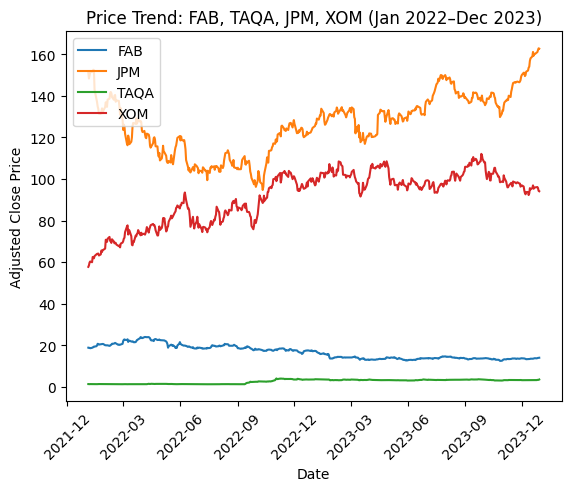

In [ ]:
#price trends over time
# we create a new figure for the plot
plt.figure()
#we loop through each company's data and plot its Adjusted close price from Jan 2022 until December 2023.
for c, g in full.groupby("Company"):
    plt.plot(g["Date"], g["AdjClose"], label=c)

# we label the plot accordingly
plt.title("Price Trend: FAB, TAQA, JPM, XOM (Jan 2022–Dec 2023)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()

# we format x-axis to show one spot for every 3 months in YEAR-MONTH format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

# we rotate the x-axis to be able to read it better
plt.xticks(rotation=45)

# we display the plot
plt.show()

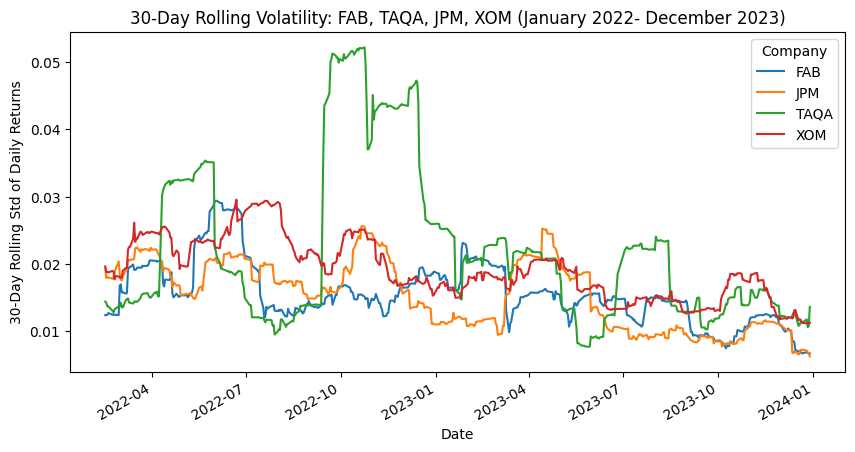

In [ ]:
#30-day rolling volatility
# rolling volatility analysis
# we calculate the 30-day rolling st. dev. (volatility) of daily returns for each stock
# then we plot the results in one figure.
ret.rolling(window=30).std().plot(figsize=(10,5))

# we label the plot accordingly
plt.title("30-Day Rolling Volatility: FAB, TAQA, JPM, XOM (January 2022- December 2023)")
plt.xlabel("Date")
plt.ylabel("30-Day Rolling Std of Daily Returns")

# we display the plot
plt.show() 

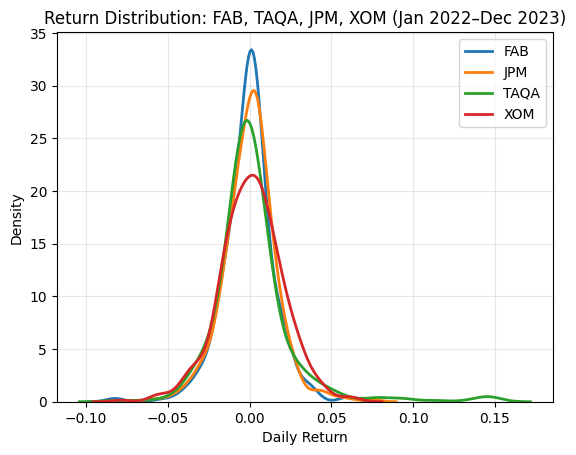

In [8]:
# return distribution analysis
# we create a new plot for the return distribution plot
plt.figure()

# we plot the return distributions (the smooth density curve) for each company
for col in ret.columns:
    sns.kdeplot(ret[col].dropna(), label=col, linewidth=2)

#we label the plot accordingly
plt.title("Return Distribution: FAB, TAQA, JPM, XOM (Jan 2022–Dec 2023)")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)

# we display the plot
plt.show()

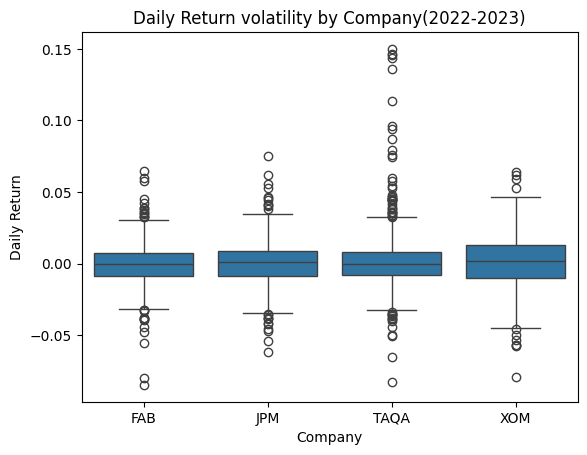

In [9]:
# volatility boxplot
# we create a new figure for the boxplot
plt.figure()

# we create boxplots of daily returns for each company and we compare volatility
sns.boxplot(data=full, x="Company", y="Return")

# we label the plot accordingly
plt.title("Daily Return volatility by Company(2022-2023)")
plt.ylabel("Daily Return")

# we display the plot
plt.show()

Correlation (FAB vs JPM): 0.047


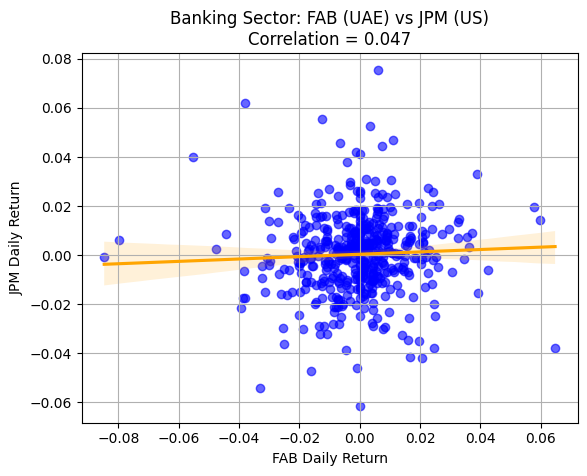

In [10]:
# banking pair: FAB vs JPM
# we calculate correlation between FAB and JPM daily returns
corr_fab_jpm = ret["FAB"].corr(ret["JPM"])
print(f"Correlation (FAB vs JPM): {corr_fab_jpm:.3f}")

# we create a scatterplot with a regression line
plt.figure()
sns.regplot(x=ret["FAB"], y=ret["JPM"],
            scatter_kws={'color':'blue', 'alpha':0.6},
            line_kws={'color':'orange'})

#we label the plot accordingly
plt.title(f"Banking Sector: FAB (UAE) vs JPM (US)\nCorrelation = {corr_fab_jpm:.3f}")
plt.xlabel("FAB Daily Return")
plt.ylabel("JPM Daily Return")
plt.grid(True)

# we display the plot
plt.show()



Correlation (TAQA vs XOM): -0.111


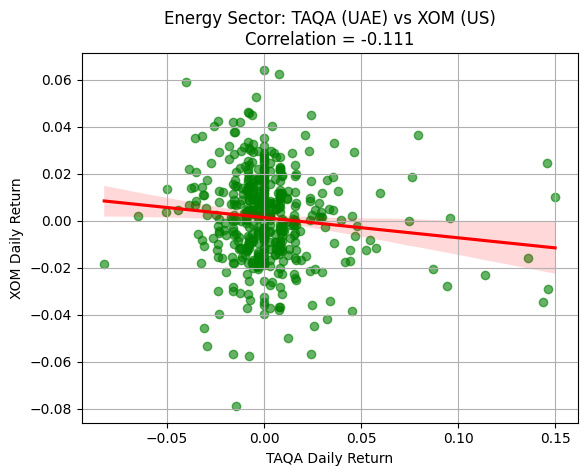

In [11]:
# energy pair: TAQA vs XOM

# we calculate correlation between TAQA and XOM daily returns
corr_taqa_xom = ret["TAQA"].corr(ret["XOM"])
print(f"Correlation (TAQA vs XOM): {corr_taqa_xom:.3f}")

# we create a scatterplot with a regression line
plt.figure()
sns.regplot(x=ret["TAQA"], y=ret["XOM"],
            scatter_kws={'color':'green', 'alpha':0.6},
            line_kws={'color':'red'})

#we label the plot accordingly
plt.title(f"Energy Sector: TAQA (UAE) vs XOM (US)\nCorrelation = {corr_taqa_xom:.3f}")
plt.xlabel("TAQA Daily Return")
plt.ylabel("XOM Daily Return")
plt.grid(True)

# we display the plot
plt.show()

Correlation (FAB vs TAQA): 0.152


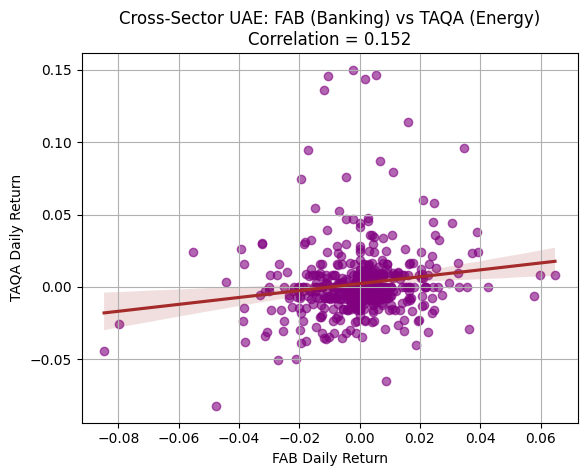

In [12]:
# cross-sector UAE pair: FAB vs TAQA

# we calculate correlation between FAB and TAQA daily returns
corr_fab_taqa = ret["FAB"].corr(ret["TAQA"])
print(f"Correlation (FAB vs TAQA): {corr_fab_taqa:.3f}")

# we create a scatterplot with a regression line
plt.figure()
sns.regplot(x=ret["FAB"], y=ret["TAQA"],
            scatter_kws={'color':'purple', 'alpha':0.6},
            line_kws={'color':'brown'})

#we label the plot accordingly
plt.title(f"Cross-Sector UAE: FAB (Banking) vs TAQA (Energy)\nCorrelation = {corr_fab_taqa:.3f}")
plt.xlabel("FAB Daily Return")
plt.ylabel("TAQA Daily Return")
plt.grid(True)

# we display the plot
plt.show()

Correlation (JPM vs XOM): 0.294


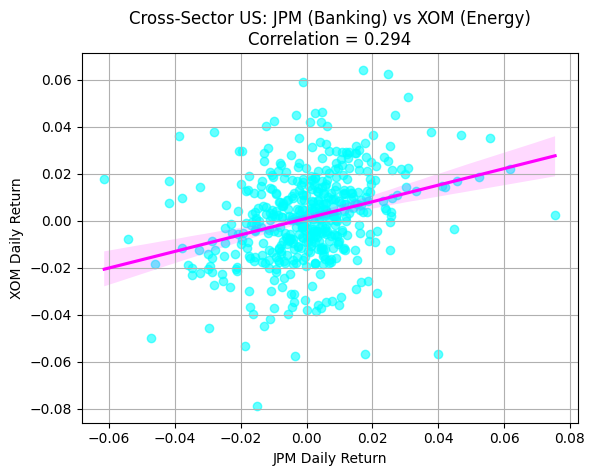

In [13]:
# cross-sector US pair: JPM vs XOM

# we calculate correlation between JPM and XOM daily returns
corr_jpm_xom = ret["JPM"].corr(ret["XOM"])
print(f"Correlation (JPM vs XOM): {corr_jpm_xom:.3f}")

# we create a scatterplot with a regression line
plt.figure()
sns.regplot(x=ret["JPM"], y=ret["XOM"],
            scatter_kws={'color':'cyan', 'alpha':0.6},
            line_kws={'color':'magenta'})

#we label the plot accordingly
plt.title(f"Cross-Sector US: JPM (Banking) vs XOM (Energy)\nCorrelation = {corr_jpm_xom:.3f}")
plt.xlabel("JPM Daily Return")
plt.ylabel("XOM Daily Return")
plt.grid(True)

# we display the plot
plt.show()

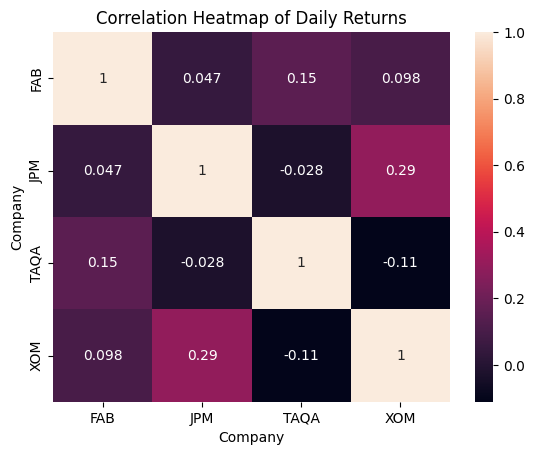

In [14]:
# heatmap/ correlation matrix 
corr_matrix=ret.corr() # compute the correlation matrix of daily returns
sns.heatmap(corr_matrix, annot=True) # create a heatmap of the correlations
plt.title("Correlation Heatmap of Daily Returns") # title
plt.show()

In [91]:
# summarize return distribution per company: mean, std, min, max
company_stats = full.groupby("Company")["Return"].agg(["mean", "std", "min", "max"])
display(company_stats)

,mean,std,min,max
Company,,,,
FAB,-0.000476,0.015886,-0.084713,0.064797
JPM,0.000353,0.016197,-0.061463,0.075510
TAQA,0.002242,0.024739,-0.082353,0.150000
XOM,0.001236,0.019198,-0.078853,0.064113


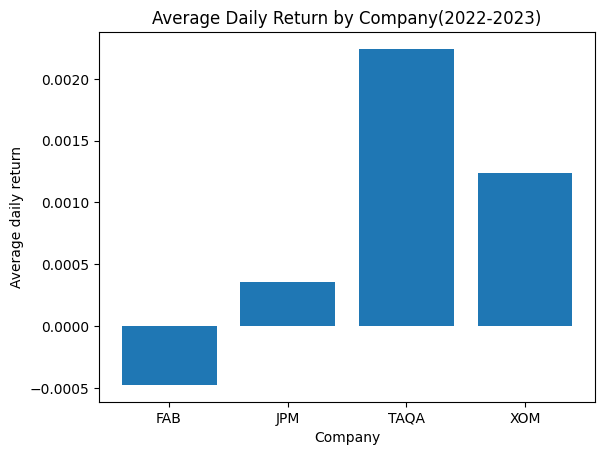

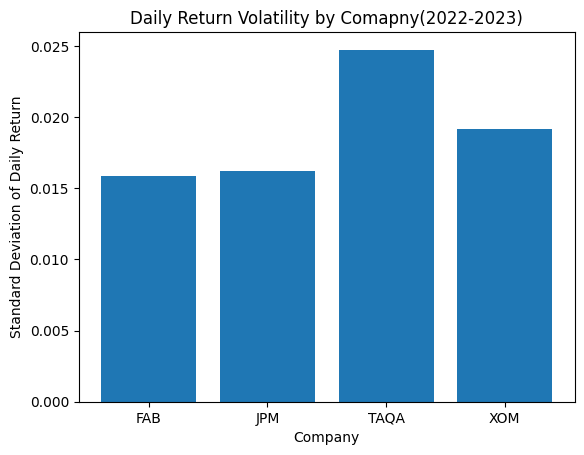

In [15]:
# mean volatility(std) of daily returns by company
stats=full.dropna(subset=["Return"]).groupby("Company")["Return"].agg(["mean", "std"]).reset_index() # group by company on the Return column

# mean return bar plot
plt.bar(stats["Company"], stats["mean"]) 
plt.xlabel("Company") # x-axis label
plt.ylabel("Average daily return") # y-axis label
plt.title("Average Daily Return by Company(2022-2023)") # title
plt.show()

# volatility bar plot(esentially std bar plot)
plt.bar(stats["Company"], stats["std"])
plt.xlabel("Company") # x-axis label
plt.ylabel("Standard Deviation of Daily Return") # y-axis label
plt.title("Daily Return Volatility by Comapny(2022-2023)") # title
plt.show()

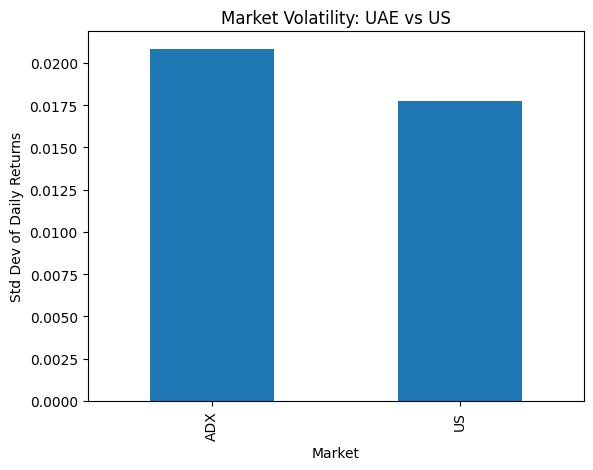

In [16]:
# market Volatility Comparison
market_vol = full.groupby("Market")["Return"].std() # group all daily returns by Market (ADX vs US) and take the std dev as a risk measure
market_vol.plot(kind="bar") # plot bar chart comparing volatility across markets
# axis labels and title
plt.xlabel("Market")
plt.ylabel("Std Dev of Daily Returns")
plt.title("Market Volatility: UAE vs US")
plt.show()

Market  Day_Type
ADX     Down        57.5
        Up          42.5
US      Up          53.0
        Down        47.0
Name: Proportion, dtype: float64

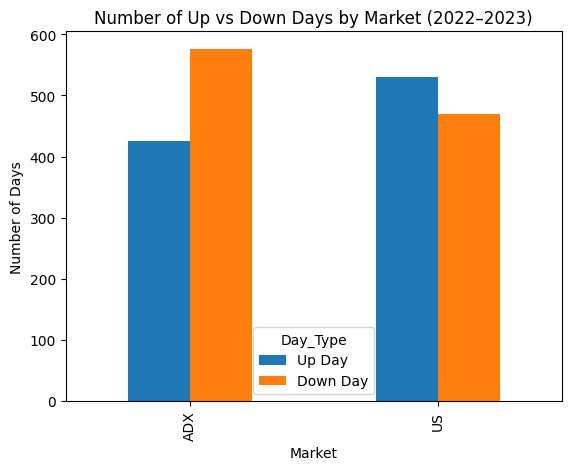

In [17]:
# up-day vs down-day comparison
day_props = full.assign(
    Day_Type = np.where(full["Return"] > 0, "Up", "Down") # classify each day
).groupby("Market")["Day_Type"].value_counts(normalize=True).rename("Proportion").mul(100).round(1) # express up/down days as percentage
display(day_props)
# add a clear up/down label for each row
full["Day_Type"] = full["Return"].apply(lambda x: "Up Day" if x > 0 else "Down Day")  
# count up vs down by market
day_counts = full.groupby("Market")["Day_Type"].value_counts().unstack().reindex(columns=["Up Day", "Down Day"])
# plot
day_counts.plot(kind="bar")
plt.xlabel("Market") # x-axis label
plt.ylabel("Number of Days") # y-axis label
plt.title("Number of Up vs Down Days by Market (2022–2023)") # title
plt.show()


In [97]:
# calculate average return (mean) and volatility (std) for each sector in each market
sector_stats = full.groupby(["Market", "Sector"])["Return"].agg(["mean", "std"]) #groupby market and sector; calculate mean and std
display(sector_stats)

mean       std
Market Sector                     
ADX    Banking -0.000476  0.015886
       Energy   0.002242  0.024739
US     Banking  0.000353  0.016197
       Energy   0.001236  0.019198

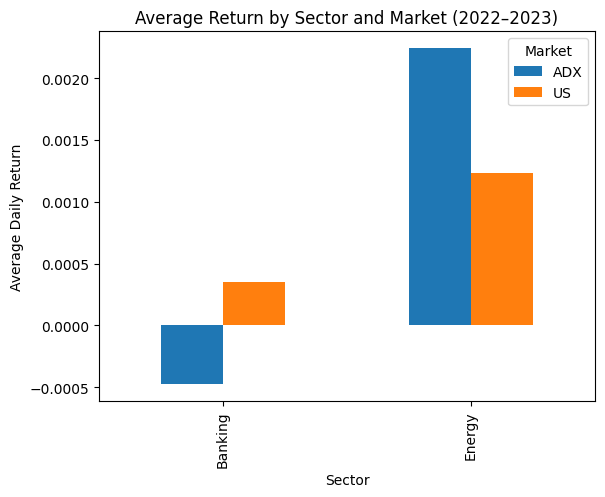

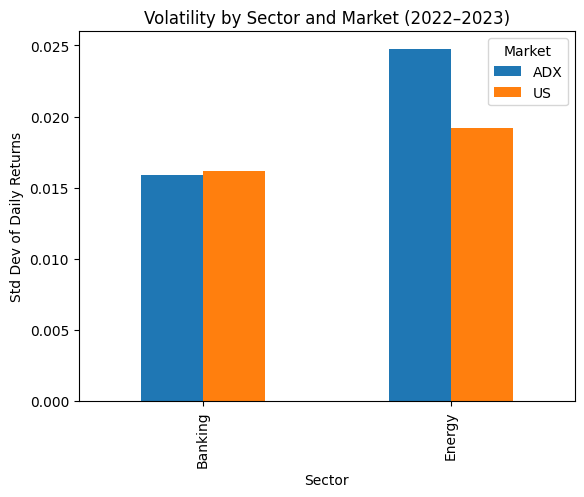

In [18]:
# build summary with a MultiIndex (Market, Sector)
sector_stats = full.groupby(["Market","Sector"])["Return"].agg(["mean","std"])
# mean reshape with unstack so market becomes columns
pivot_mean = sector_stats["mean"].unstack("Market")
pivot_mean.plot(kind="bar")
plt.title("Average Return by Sector and Market (2022–2023)")
plt.ylabel("Average Daily Return")
plt.xlabel("Sector")
plt.legend(title="Market")
plt.show()
# std same reshaping for volatility
pivot_std = sector_stats["std"].unstack("Market")
pivot_std.plot(kind="bar")
plt.title("Volatility by Sector and Market (2022–2023)")
plt.ylabel("Std Dev of Daily Returns")
plt.xlabel("Sector")
plt.legend(title="Market")
plt.show()